<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/N2_O2_CO2_NVT_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install

In [110]:
# jax molecular dynamics
!pip install jax-md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import

In [111]:

import numpy as onp

from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax
from jax import ops

import time

from jax_md import space, smap, energy, minimize, quantity, simulate

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')


  


Experiment configuration

In [112]:
N = 400
dimension = 3
box_size = quantity.box_size_at_number_density( N, 0.8, dimension)
dt = 5e-3
displacement, shift = space.periodic(box_size) 

write_every = 100


kT = lambda t: np.where(t < 5000.0 * dt, 0.01, 0.012)

Helper functions

In [113]:
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

In [114]:
def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)

In [115]:
def step_fn(i, state_and_log):
  state, log = state_and_log

  t = i * dt

  # Log information about the simulation.
  T = quantity.temperature(state.velocity)
  log['kT'] = log['kT'].at[i].set(T)
  H = simulate.nvt_nose_hoover_invariant(energy_fn, state, kT(t))
  log['H'] = log['H'].at[i].set(H)
  # Record positions every `write_every` steps.
  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: \
                             p.at[i // write_every].set(state.position),
                             lambda p: p,
                             log['position'])

  # Take a simulation step.
  state = apply(state, kT=kT(t))



  return state, log

In [116]:
key = random.PRNGKey(0)

In [117]:
key, split = random.split(key)
R = box_size * random.uniform(split, (N, dimension), dtype=np.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
# sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
sigma = np.array([[0.3, 1.2], [1.2, 1.4]])
N_2 = int(N / 5)
N_3 = int(N / 50)

buf = 0
buf_lst = []
for i in range(0, N):

  if buf < N_3:
    buf_lst.append(0)
  elif buf < N_2:
    buf_lst.append(1)
  else:
    buf_lst.append(2)

  buf += 1

In [118]:
species = np.array(buf_lst)


In [119]:
species.shape

(400,)

In [120]:
energy_fn = energy.soft_sphere_pair(displacement, species=species, sigma=sigma)

init, apply = simulate.nvt_nose_hoover(energy_fn, shift, dt, kT(0.))
state = init(key, R)

In [121]:
steps = 10000

log = {
    'kT': np.zeros((steps,)),
    'H': np.zeros((steps,)),
    'position': np.zeros((steps // write_every,) + R.shape) 
}

state, log = lax.fori_loop(0, steps, step_fn, (state, log))

R = state.position

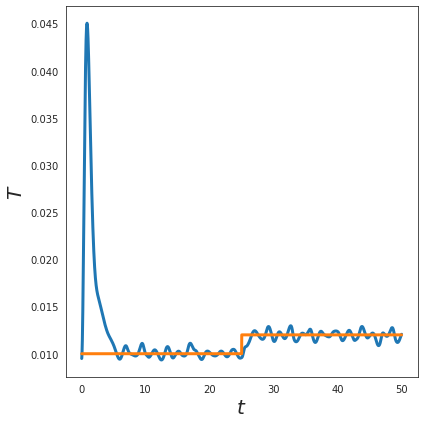

In [122]:
t = onp.arange(0, steps) * dt
plt.plot(t, log['kT'], linewidth=3)
plt.plot(t, kT(t), linewidth=3)
format_plot('$t$', '$T$')
finalize_plot()

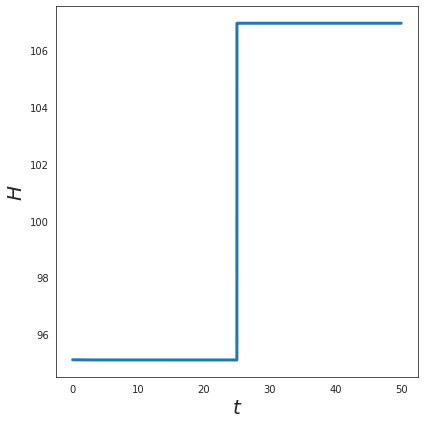

In [123]:
plt.plot(t, log['H'], linewidth=3)
format_plot('$t$', '$H$')
finalize_plot()

In [124]:
buf_lst = []
for i in species:
   
  # carbon dioxide
  if i == 0: 
    buf_lst.append(np.array([1.5, 3.2, 0.01]))
  
  # oxygen
  elif i == 1: 
    buf_lst.append(np.array([1.0, 0.2, 0.5]))   

  # nitrogen
  elif i == 2: 
    buf_lst.append(np.array([0.3, .8, 0.85]))        


In [125]:
from jax_md.colab_tools import renderer

diameters = sigma[species, species]

colors = np.array(buf_lst)

renderer.render(box_size,
                {
                    #'particles': renderer.Disk(log['position'], 
                    #                           diameters,
                    #                           colors)
                    'particles': renderer.Sphere(log['position'], 
                                               diameters,
                                               colors)   
                                      
                },
                resolution=(600, 600))

In [50]:
log['position'].shape

(100, 400, 3)

In [51]:
initial_positions = log['position'][0]

In [52]:
log['position'][1]

DeviceArray([[22.32846559, 13.51262532, 17.20230863],
             [10.69839986,  0.18938342,  0.20342269],
             [11.0354126 ,  3.20344227,  9.62985994],
             ...,
             [ 5.61945919,  5.20497938, 21.05951849],
             [11.94560568, 21.22870894, 16.91103224],
             [11.93135059, 11.4645504 ,  0.81510133]], dtype=float64)

In [53]:
import imageio
import jax.numpy as jnp

def make_from_image(filename, size_in_pixels):
  position = []
  angle = []
  color = []

  img = imageio.imread(filename)

  scale = 2**(1/6)
  ratio = jnp.sqrt(1 - 0.25)
  for i, y in enumerate(range(0, img.shape[0], size_in_pixels)):
    for x in range(0, img.shape[1], size_in_pixels):
      r, g, b, a = img[y, x]
      if a == 255:
        hshift = size_in_pixels * (i % 2) / 2.0
        position += [[scale * (x + hshift) / size_in_pixels, scale * (img.shape[0] - y) / size_in_pixels * ratio]]
        color += [[r / 255, g / 255, b / 255]]
  img_size = jnp.array(img.shape[:2]).T / size_in_pixels * scale
  box_size = jnp.max(img_size) * 1.5
  position = jnp.array(position, jnp.float64) + box_size / 2.0 - img_size / 2
  color = jnp.array(color, jnp.float64)

  return box_size, position, color

In [54]:
box, positions, colors = make_from_image('mfi_three.png', 24)

In [55]:
from jax_md.colab_tools import renderer

renderer.render(box,
                renderer.Disk(positions, color=colors))

In [56]:
from jax_md import space

displacement_fn, shift_fn = space.periodic(box)

In [57]:
positions[0]

DeviceArray([34.09478472, 63.52702279], dtype=float64)

In [58]:
displacement_fn(positions[0], positions[-1])

DeviceArray([40.12801823, 42.77154854], dtype=float64)

In [59]:
shift_fn(positions[0], jnp.array([10.0, 0.0]))

DeviceArray([44.09478472, 63.52702279], dtype=float64)

## Energy

"Energy" in Physics plays a similar role to "Loss" in machine learning. 

Write down an energy function between two grains of sand, $\epsilon(r)$. 

The total energy will be the sum of all pairs of energies.

$$E = \sum_{i,j} \epsilon(r_{ij})$$

where $r_{ij}$ is the distance between grain $i$ and grain $j$.


We want to model wet sand:

*   Grains are hard (no interpenetration).
*   Grains stick together a little bit.
*   Grains far away from one another don't notice each other.

Text(0, 0.5, '$\\epsilon$')

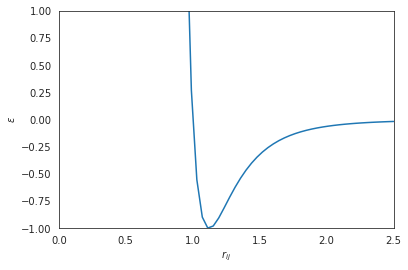

In [60]:
from jax_md import energy

rs = jnp.linspace(0.5, 2.5)
plt.plot(rs, energy.lennard_jones(rs))

plt.ylim([-1, 1])
plt.xlim([0, 2.5])
plt.xlabel('$r_{ij}$')
plt.ylabel('$\\epsilon$')

In [61]:
sand_energy = energy.lennard_jones_pair(displacement_fn)

sand_energy(positions)

DeviceArray(-10178.13324477, dtype=float64)

## Simulate

In [62]:
from jax import random

simulation_steps = 10000
write_every = 50
key = random.PRNGKey(1)

In [63]:
from jax_md import simulate
from jax import jit

init_fn, step_fn = simulate.nvt_langevin(sand_energy, shift_fn, dt=5e-3, kT=0.0, gamma=1e-2)

sand = init_fn(key, positions)
step_fn = jit(step_fn)

In [64]:

# trajectory = []

# for i in range(simulation_steps):
#  if i % write_every == 0:
#    trajectory += [sand.position]
    
#  sand = step_fn(sand)

# trajectory = jnp.stack(trajectory)

In [65]:
# renderer.render(box, renderer.Disk(trajectory, color=colors))